In [1]:
#캐릭터 분석을 위해서 인물을 추출하고 인물과의 관계를 분석하기 위해서 standford의 SentiWordNet을 활용하여 인물들이 포함된 문장의 감정을 추출하여 분석할 것이다.

In [2]:
import gensim
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from nltk.tokenize import sent_tokenize
import multiprocessing
import os
from pathlib import Path
import io
from gensim.models import Phrases
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import random

In [3]:
def load_data():
    dir = 'data/'
    potter_corpus = u''
    for i in range(7):
        with io.open(dir + 'HarvardEssays.txt'.format(i + 1), 'r', encoding='utf-8') as file:
            potter_corpus += file.read()
        potter_corpus += ' '
    return potter_corpus

In [4]:
load_data()

'Statistical Physics is a comedy in long-shot. Professor Nir Gov’s lecture (held during the summer camp at the Weizmann Institute of Science, Israel) covered a single topic in physics. However, its application was truly versatile—from cell dynamics to the collaboration patterns of ants. Full of curiosity, I approached him after the lecture and asked to learn more about the magical tool known as Statistical Physics. \n\n“Start with ensemble theory,” he advised. \n\nThough, Statistical Physics seemed more of a tragedy, seen in close-up. Spending weeks with several textbooks, I found myself in a maze. \n\nTo understand a system, you shall calculate every component’s behavior. This commandment summarizes the physics I had learned for three years at Korea Science Academy (KSA). However, when we consider a system with a myriad of particles, this directive is defied by the virtual impossibility of figuring out the motions of every particle. Instead, physicists construct the ensemble of macros

In [5]:
def preprocessing(corpus):
    sentences = sent_tokenize(corpus)
    split_sentences = []
    for sentence in sentences:
        processed = re.sub("[^a-zA-Z]", " ", sentence)
        words = processed.split()
        split_sentences.append(words)
    return split_sentences, sentences

In [6]:
def word2vector(corpus, sentences): #Use NLP model **word2vector** to analyze the relationship between characters
    skip_gram = 1
    workers = multiprocessing.cpu_count()
    bigram_transformer = Phrases(corpus) ##TODO: define bigram transformer, find common combination
    model = gensim.models.word2vec.Word2Vec(bigram_transformer[corpus], workers=workers, sg=skip_gram,min_count=5)##TODO: define model
    model.train(corpus, total_examples=sum([len(sentence) for sentence in sentences]), epochs=50)##TODO: train 20 epochs
    model.save('trained_model/' + 'potter2vec.w2v')
    return model

In [7]:
def random_color():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

In [8]:
def load_character():
    path = 'Characters_directory/'
    characters_dir = os.listdir(path)
    columns = []
    name_entities_dictionary = defaultdict(list)
    for file in characters_dir:
        pattern = r'(.+?)\.'
        name = re.findall(pattern,file)[0]
        columns.append(name)
        f = open(path + file, 'r')
        for line in f.readlines():
            line = line.strip('\n')
            line = line.strip()
            line = line.lower()
            if len(line):
                name_entities_dictionary[name].append(line)

    whole_possible_name_entities_list = []
    for i in name_entities_dictionary.values():
        for j in i:
            whole_possible_name_entities_list.append(j)

    ##List to numpy because of efficiency
    whole_possible_name_entities = np.array(whole_possible_name_entities_list)
    return whole_possible_name_entities, name_entities_dictionary

In [9]:
def get_key(dict, value):
    for key in dict.keys():
        if value in dict[key]:
            return key

def draw_network(characters_dict, similarity_dict):
    plt.figure(figsize=(20,14))
    colors = []
    G = nx.Graph()

    name_list = list(characters_dict.keys())
    pairs = list(similarity_dict.keys())
    pattern = '([A-Za-z]{2,25})_[A-Za-z]{2,25}'
    for j in range(len(name_list)):
        name = name_list[j]
        first_name = re.findall(pattern, name)[0]
        G.add_node(first_name)
        colors.append(random_color())



    for j in range(len(pairs)):
        similarity = similarity_dict[pairs[j]]
        print(similarity)
        name_paris = pairs[j].split(',')
        top_name = name_paris[0]
        bottom_name = name_paris[1]
        top_first_name = re.findall(pattern, top_name)[0]
        bottom_first_name = re.findall(pattern, bottom_name)[0]
        G.add_edge(top_first_name, bottom_first_name, weight=similarity*10)


    pos = nx.spring_layout(G,k=0.5,iterations=50)
    plt.title("Relationships between top 30 characters in Harry Potter Series")
    nx.draw(G, pos, with_labels=True, node_color=colors, font_size=12, node_size=1200, width=2)


    plt.show()

In [10]:
def similarity_analysis(model, name1, name2):
    ##TODO: Check whether the name entities in our model's vocabulary
    if name1 in model.wv.vocab and name2 in model.wv.vocab:
        similarity = model.similarity(name1, name2)
    else:
        similarity = None

    return similarity
    # print(model.most_similar_cosmul('voldemort'))

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.


Similarity between Rubeus_Hagrid and Ron_Ronald_Weasley is 0.5285744071006775.
Similarity between Dobby_Dobby and Harry_James_Potter is 0.5666553378105164.
Similarity between Dobby_Dobby and Kreacher_Kreacher is 0.6267542839050293.
Similarity between Cho_Chang and Ginny_Weasley is 0.5746580958366394.
Similarity between Cho_Chang and Viktor_Krum is 0.513634979724884.
Similarity between Cho_Chang and Viktor_Krum is 0.5344530344009399.
Similarity between Cho_Chang and Molly_Weasley is 0.541113018989563.
Similarity between Argus_Filch and Minerva_McGonagall is 0.5110620260238647.
Similarity between Argus_Filch and Severus_Snape is 0.503783643245697.
Similarity between Albus_Dumbledore and Horace_Slughorn is 0.5812860727310181.
Similarity between Albus_Dumbledore and Harry_James_Potter is 0.5616495609283447.
Similarity between Albus_Dumbledore and Cornelius_Oswald_Fudge is 0.5340369939804077.
Similarity between Albus_Dumbledore and Cornelius_Oswald_Fudge is 0.5689802765846252.
Similarity be

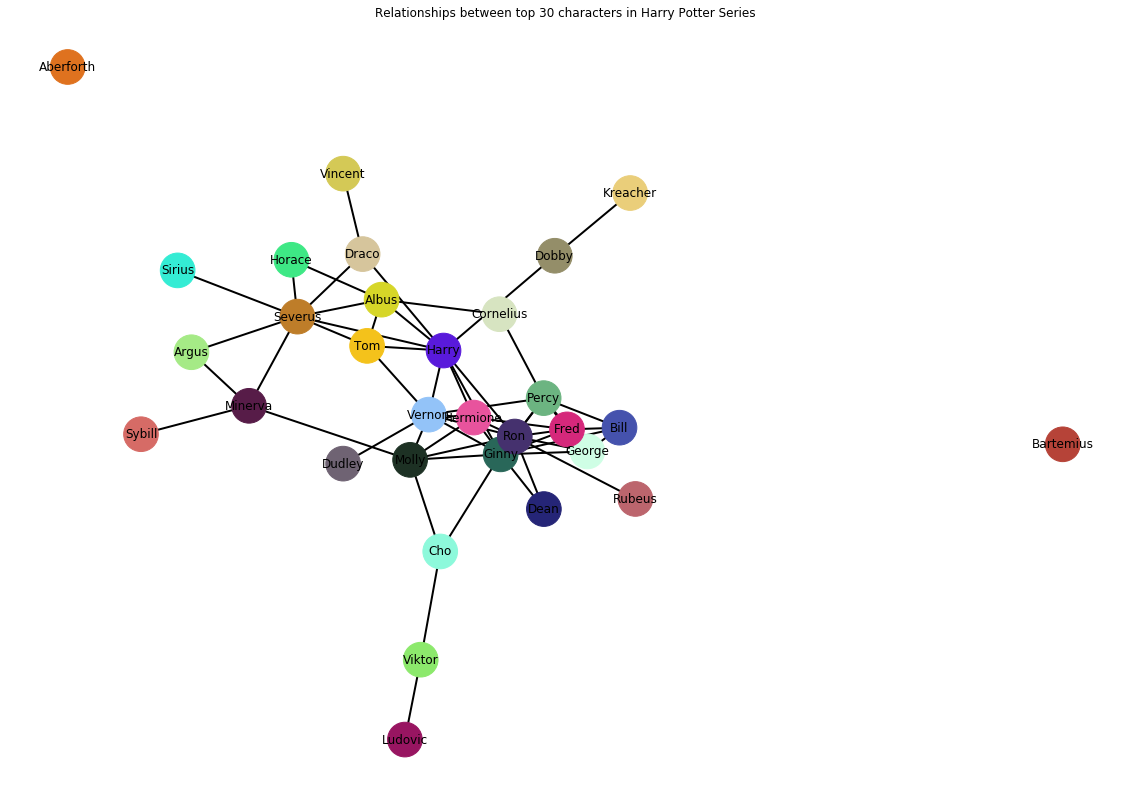

In [11]:
    similarity_dict = {}
    corpus = load_data()
    processed_corpus, raw_sentences = preprocessing(corpus)
    model_file = Path('trained_model/' + 'potter2vec.w2v')
    if not model_file.exists():
        model = word2vector(processed_corpus, raw_sentences)
    else:
        model = gensim.models.word2vec.Word2Vec.load('trained_model/' + 'potter2vec.w2v')
    #print(model.wv.vocab)
    # similarity_analysis(model)
    characters, characters_dict = load_character()
    length = characters.shape[0]
    for i in range(length):
        for j in range(length):
            ##TODO: 1. Similarity value must larger than threshold
            ##      2. Get the key of different name entities.
            ##      3. If the paris of characters are existed, compare the similarity values, if larger than previous one, update.
            similarity = similarity_analysis(model, characters[i], characters[j])
            threshold = 0.5
            if similarity != None:
                if similarity >= threshold:
                    key1 = get_key(characters_dict, characters[i])
                    key2 = get_key(characters_dict, characters[j])
                    if key1 != key2:
                        if (('{},{}'.format(key1,key2) not in similarity_dict.keys()) and ('{},{}'.format(key2,key1) not in similarity_dict.keys())):
                            print('Similarity between {} and {} is {}.'.format(key1, key2, similarity))
                            similarity_dict['{},{}'.format(key1,key2)] = similarity

                        else:
                            if '{},{}'.format(key1, key2) in similarity_dict.keys():
                                if similarity_dict['{},{}'.format(key1, key2)] < similarity:
                                    print('Similarity between {} and {} is {}.'.format(key1, key2, similarity))
                                    similarity_dict['{},{}'.format(key1, key2)] = similarity

                            if '{},{}'.format(key2, key1) in similarity_dict.keys():
                                if similarity_dict['{},{}'.format(key2, key1)] < similarity:
                                    print('Similarity between {} and {} is {}.'.format(key2, key1, similarity))
                                    similarity_dict['{},{}'.format(key2, key1)] = similarity



    print(similarity_dict)
    print('Totally {} pairs.'.format(len(similarity_dict.keys())))
    draw_network(characters_dict, similarity_dict)